In [1]:
# The MIT License (MIT) Copyright (c) 2023 milmor
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# FastGAN
- En este notebook se define una arquitectura basada en [FastGAN](https://arxiv.org/abs/2101.04775).
- El código completo en Tensorflow se encuentra en [este repositorio](https://github.com/milmor/self-supervised-gan).

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

- Descarga dataset.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 
test_images = (test_images - 127.5) / 127.5 

## 1.- Pipeline

In [4]:
def deprocess(img):
    return img * 127.5 + 127.5

In [5]:
def create_ds(images, batch_size, seed=15):
    BUFFER_SIZE = images.shape[0]
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    ds = img_ds.cache().shuffle(
        BUFFER_SIZE, seed=seed).batch(
        batch_size, drop_remainder=True, num_parallel_calls=AUTOTUNE).prefetch(
        AUTOTUNE
    )
    print(f'Train dataset size: {BUFFER_SIZE}')
    print(f'Train batches: {tf.data.experimental.cardinality(ds)}')
    return ds

batch_size = 128
train_dataset = create_ds(train_images, batch_size)

Train dataset size: 50000
Train batches: 390


In [6]:
train_batch = next(iter(train_dataset))

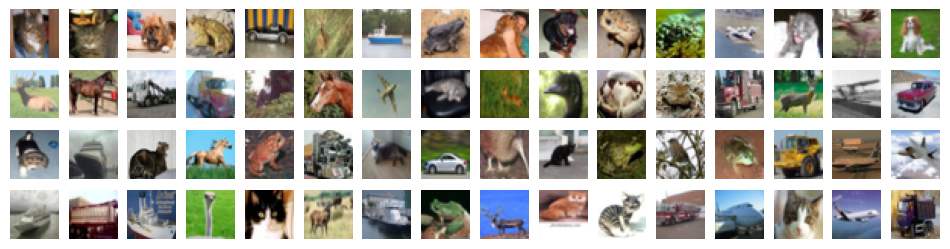

In [7]:
def plot_batch(batch):
    plt.figure(figsize=(12, 3))
    n_images = 64
    plot_batch = tf.cast(deprocess(batch), tf.uint8)
    for i in range(n_images):
        plt.subplot(4, 16, i+1)
        plt.imshow(plot_batch[i, :, :, :])
        plt.axis('off')
    plt.show()
     
plot_batch(train_batch)

## 2.- Modelo
### Generador
- Define bloque para UpSampling.

In [8]:
def upBlock(filters, kernel_size=3, initializer='orthogonal'):
    block = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(filters*2, kernel_size=kernel_size, 
                padding='same', use_bias=False,
                kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
    ])
    return block

In [9]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters=128, dense_units=512, initializer='glorot_uniform'):
        super(Generator, self).__init__()
        self.init = tf.keras.Sequential([
            layers.Dense(4 * 4 * dense_units, 
                         use_bias=False, kernel_initializer=initializer),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Reshape((4, 4, dense_units))
        ])     
        self.up_8 = upBlock(filters, initializer=initializer)
        self.up_16 = upBlock(filters // 2, initializer=initializer)
        self.up_32 = upBlock(filters // 4, initializer=initializer)
        self.ch_conv = layers.Conv2D(3, 3, padding='same', 
                                     activation='tanh', kernel_initializer=initializer)      
                       
    def call(self, z):
        feat_4 = self.init(z)
        feat_8 = self.up_8(feat_4)  
        feat_16 = self.up_16(feat_8)
        feat_32 = self.up_32(feat_16)
        img = self.ch_conv(feat_32)
        return img

    
noise_dim = 64
noise = tf.random.normal([batch_size, noise_dim])
generator = Generator(64, 64)

In [10]:
gen_batch = generator(noise)
generator.summary()
print(gen_batch.shape)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 4, 4, 64)           69632     
                                                                 
 sequential_1 (Sequential)   (128, 8, 8, 128)          74240     
                                                                 
 sequential_2 (Sequential)   (128, 16, 16, 64)         73984     
                                                                 
 sequential_3 (Sequential)   (128, 32, 32, 32)         18560     
                                                                 
 conv2d_3 (Conv2D)           multiple                  867       
                                                                 
Total params: 237,283
Trainable params: 234,787
Non-trainable params: 2,496
_________________________________________________________________
(128, 32, 32, 3)


### Discriminador

- Define bloque residual.

In [11]:
def convBlock(filters, kernel_size=3, strides=1, padding='same', 
              use_bias=False, kernel_initializer='orthogonal', use_bn=True):
    if use_bn:
        block = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=kernel_size, strides=strides,
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer),
            layers.BatchNormalization()
         ])
    else:
        block = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, 
                padding='same', use_bias=use_bias, kernel_initializer=kernel_initializer)
    return block

In [12]:
class DownBlockComp(layers.Layer):
    def __init__(self, filters, initializer='orthogonal', use_bn=True):
        super(DownBlockComp, self).__init__()

        self.main = tf.keras.Sequential([
            convBlock(filters, kernel_size=4, padding='same',
                strides=2, use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
            convBlock(filters, kernel_size=3, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])
        
        self.direct = tf.keras.Sequential([
            layers.AveragePooling2D((2, 2)),
            convBlock(filters, kernel_size=1, padding='same',
                use_bias=False, kernel_initializer=initializer, use_bn=use_bn),
            layers.LeakyReLU(0.2),
        ])

    def call(self, x):
        return (self.main(x) + self.direct(x)) / 2

In [13]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters=128, initializer='orthogonal', use_bn=True):
        super(Discriminator, self).__init__()
        '''Encode image'''
        self.down_from_big = tf.keras.Sequential([
            layers.Conv2D(filters // 4, kernel_size=3, padding='same', 
                use_bias=False, kernel_initializer=initializer),
            layers.LeakyReLU(0.2)
        ])
        self.down_16 = DownBlockComp(filters // 2, initializer=initializer, use_bn=use_bn)
        self.down_8 = DownBlockComp(filters, initializer=initializer, use_bn=use_bn)

        '''Logits'''
        self.logits = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, padding='valid', 
                use_bias=False, kernel_initializer=initializer),  
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, kernel_size=4, padding='valid', 
                use_bias=False, kernel_initializer=initializer), 
            layers.Flatten()
        ])
 
    def call(self, img):
        feat_32 = self.down_from_big(img)
        feat_16 = self.down_16(feat_32)
        feat_8 = self.down_8(feat_16)

        logits = self.logits(feat_8)
        return logits
    
    
discriminator = Discriminator(128, use_bn=False)
out_disc = discriminator(train_batch)
discriminator.summary()
out_disc.shape

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (128, 32, 32, 32)         864       
                                                                 
 down_block_comp (DownBlockC  multiple                 71680     
 omp)                                                            
                                                                 
 down_block_comp_1 (DownBloc  multiple                 286720    
 kComp)                                                          
                                                                 
 sequential_9 (Sequential)   (128, 25)                 18432     
                                                                 
Total params: 377,696
Trainable params: 377,696
Non-trainable params: 0
_________________________________________________________________


TensorShape([128, 25])

## 3.- Entrenamiento
- Define funciones objetivo y optimizadores.

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
g_lr = 0.0001
d_lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9

g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr, 
                                 beta_1=beta_1, 
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr, 
                                 beta_1=beta_1,
                                 beta_2=beta_2)

- Define GAN.

In [17]:
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, g_opt, d_opt, g_loss, d_loss):
        super(GAN, self).__init__()
        self.generator = generator
        self.g_opt = g_opt
        self.g_loss = g_loss
        self.discriminator = discriminator
        self.d_opt = d_opt
        self.d_loss = d_loss
        
        # Log metrics
        self.g_loss_avg = tf.keras.metrics.Mean()
        self.d_loss_avg = tf.keras.metrics.Mean()

    @tf.function
    def train_step(self, real_img):
        noise = tf.random.normal([batch_size, noise_dim])

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            gen_img = self.generator(noise, training=True)
            real_out = self.discriminator(real_img, training=True)
            fake_out = self.discriminator(gen_img, training=True)

            disc_loss = self.d_loss(real_out, fake_out)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables)) 

        noise = tf.random.normal([batch_size, noise_dim])

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generator_output = self.generator(noise, training=True)
            fake_out = self.discriminator(generator_output, training=True)

            gen_loss = self.g_loss(fake_out)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        
        self.g_loss_avg(gen_loss)
        self.d_loss_avg(disc_loss)

- Define modelo.

In [18]:
gan = GAN(generator, discriminator, 
          g_opt, d_opt, 
          generator_loss, discriminator_loss)

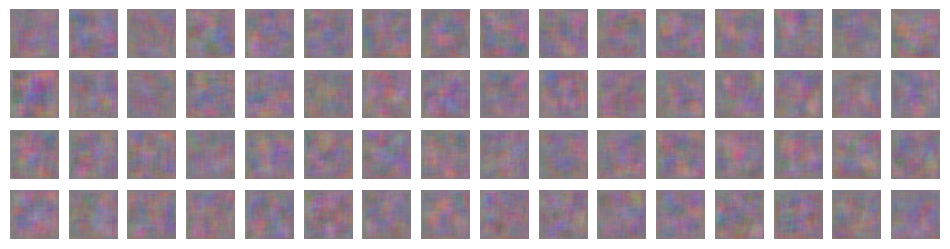

In [19]:
noise = tf.random.normal([batch_size, noise_dim])
gen_batch = gan.generator(noise)

plot_batch(gen_batch)

In [20]:
noise_seed = tf.random.normal([batch_size, noise_dim])

In [21]:
epochs = 50
plot_inter = 10

def train(model, epochs, dataset, plot_inter):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            model.train_step(image_batch)

        g_loss = model.g_loss_avg.result()
        d_loss = model.d_loss_avg.result()
        print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec G loss: {g_loss:.4f} D loss: {d_loss:.4f}')
        if epoch % plot_inter == 0:
            gen_batch = model.generator(noise_seed, training=False)
            plot_batch(gen_batch)
            
        model.g_loss_avg.reset_states()
        model.d_loss_avg.reset_states()

Time for epoch 0 is 9.4134 sec G loss: 0.9495 D loss: 1.3011


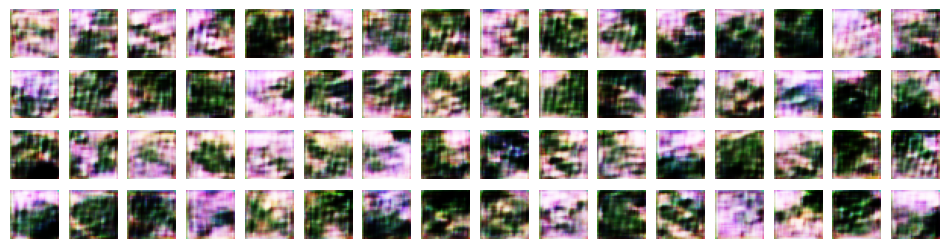

Time for epoch 1 is 5.0823 sec G loss: 0.8483 D loss: 1.3243
Time for epoch 2 is 5.0867 sec G loss: 0.7562 D loss: 1.3501
Time for epoch 3 is 5.0939 sec G loss: 0.7524 D loss: 1.3353
Time for epoch 4 is 5.0965 sec G loss: 0.7431 D loss: 1.3475
Time for epoch 5 is 5.1062 sec G loss: 0.7325 D loss: 1.3417
Time for epoch 6 is 5.1172 sec G loss: 0.7367 D loss: 1.3353
Time for epoch 7 is 5.1085 sec G loss: 0.7395 D loss: 1.3389
Time for epoch 8 is 5.1186 sec G loss: 0.7294 D loss: 1.3427
Time for epoch 9 is 5.1235 sec G loss: 0.7259 D loss: 1.3382
Time for epoch 10 is 5.1241 sec G loss: 0.7236 D loss: 1.3394


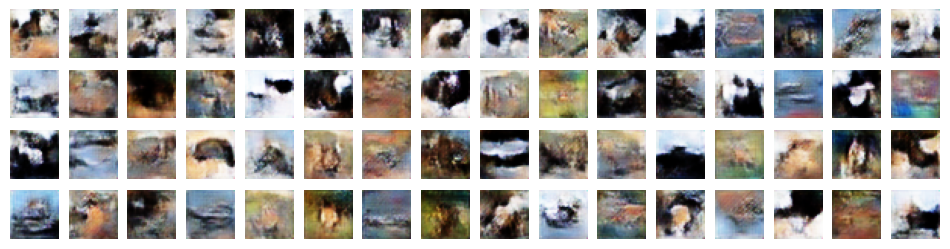

Time for epoch 11 is 5.1134 sec G loss: 0.7267 D loss: 1.3326
Time for epoch 12 is 5.1228 sec G loss: 0.7270 D loss: 1.3268
Time for epoch 13 is 5.1307 sec G loss: 0.7256 D loss: 1.3278
Time for epoch 14 is 5.1291 sec G loss: 0.7224 D loss: 1.3252
Time for epoch 15 is 5.1342 sec G loss: 0.7262 D loss: 1.3241
Time for epoch 16 is 5.1379 sec G loss: 0.7205 D loss: 1.3240
Time for epoch 17 is 5.1401 sec G loss: 0.7201 D loss: 1.3230
Time for epoch 18 is 5.1389 sec G loss: 0.7207 D loss: 1.3197
Time for epoch 19 is 5.1449 sec G loss: 0.7188 D loss: 1.3215
Time for epoch 20 is 5.1488 sec G loss: 0.7215 D loss: 1.3166


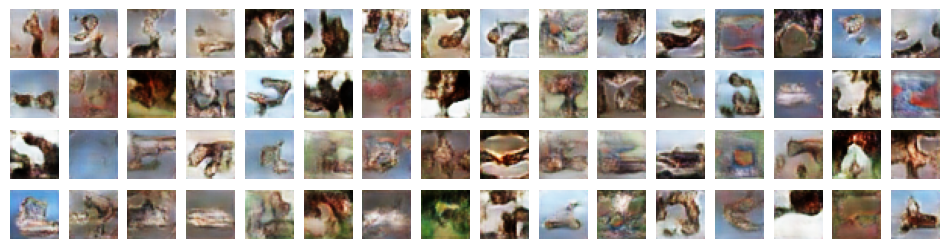

Time for epoch 21 is 5.1470 sec G loss: 0.7256 D loss: 1.3079
Time for epoch 22 is 5.1470 sec G loss: 0.7247 D loss: 1.3037
Time for epoch 23 is 5.1412 sec G loss: 0.7277 D loss: 1.3030
Time for epoch 24 is 5.1512 sec G loss: 0.7291 D loss: 1.2948
Time for epoch 25 is 5.1482 sec G loss: 0.7274 D loss: 1.2945
Time for epoch 26 is 5.1417 sec G loss: 0.7336 D loss: 1.2955
Time for epoch 27 is 5.1440 sec G loss: 0.7319 D loss: 1.2929
Time for epoch 28 is 5.1475 sec G loss: 0.7342 D loss: 1.2864
Time for epoch 29 is 5.1468 sec G loss: 0.7364 D loss: 1.2866
Time for epoch 30 is 5.1473 sec G loss: 0.7370 D loss: 1.2819


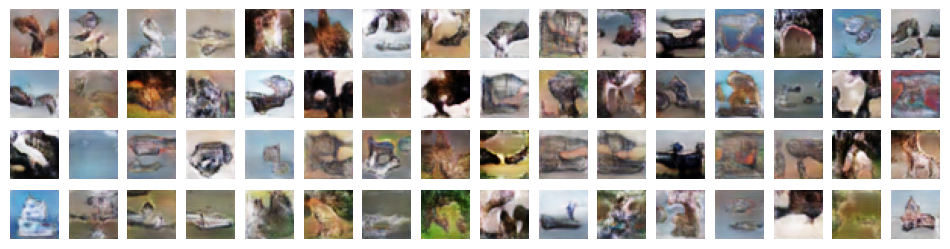

Time for epoch 31 is 5.1542 sec G loss: 0.7342 D loss: 1.2786
Time for epoch 32 is 5.1518 sec G loss: 0.7388 D loss: 1.2741
Time for epoch 33 is 5.1587 sec G loss: 0.7396 D loss: 1.2734
Time for epoch 34 is 5.1586 sec G loss: 0.7376 D loss: 1.2682
Time for epoch 35 is 5.1624 sec G loss: 0.7418 D loss: 1.2626
Time for epoch 36 is 5.1599 sec G loss: 0.7404 D loss: 1.2601
Time for epoch 37 is 5.1570 sec G loss: 0.7414 D loss: 1.2579
Time for epoch 38 is 5.1573 sec G loss: 0.7365 D loss: 1.2525
Time for epoch 39 is 5.1583 sec G loss: 0.7427 D loss: 1.2518
Time for epoch 40 is 5.1570 sec G loss: 0.7411 D loss: 1.2467


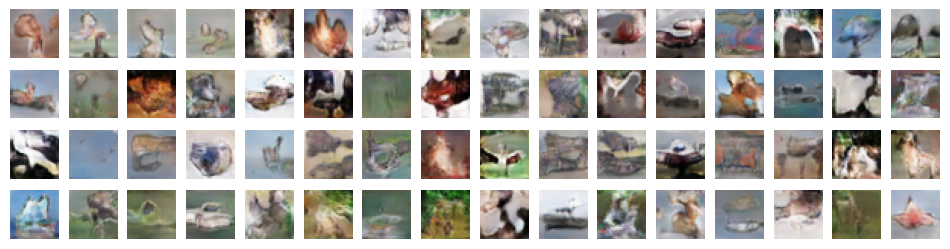

Time for epoch 41 is 5.1565 sec G loss: 0.7438 D loss: 1.2463
Time for epoch 42 is 5.1571 sec G loss: 0.7481 D loss: 1.2423
Time for epoch 43 is 5.1676 sec G loss: 0.7467 D loss: 1.2352
Time for epoch 44 is 5.1652 sec G loss: 0.7504 D loss: 1.2342
Time for epoch 45 is 5.1585 sec G loss: 0.7503 D loss: 1.2315
Time for epoch 46 is 5.1643 sec G loss: 0.7547 D loss: 1.2261
Time for epoch 47 is 5.1565 sec G loss: 0.7589 D loss: 1.2217
Time for epoch 48 is 5.1590 sec G loss: 0.7562 D loss: 1.2189
Time for epoch 49 is 5.1574 sec G loss: 0.7571 D loss: 1.2143


In [22]:
train(gan, epochs, train_dataset, plot_inter)

- Agregando normalización por lotes en el discriminador.

- La normalización por lotes consiste en normalizar los lotes de salida $b \in \mathbb{R}^{N\times C\times H\times W}$ de una capa $\ell$:


\begin{equation}
\text{BN}(b_{\ell})=  \gamma_{\ell} \odot  \left(\frac{b_{\ell}- \mu}{\sigma}\right)+ \beta_{\ell}
\end{equation}
donde $ \gamma_{\ell}, \beta_{\ell} \in \mathbb{R}^{C}$ son parámetros que se entrenan y $ \mu, \sigma \in \mathbb{R}^{C}$ son la media y la desviación estándar de los lotes:
\begin{equation}
\mu = \frac{1}{NHW}\sum_{n=1}^{N}\sum_{h=1}^{H}\sum_{w=1}^{W}b_{\ell}^{nchw}
\end{equation}

\begin{equation}
\sigma = \sqrt{\frac{1}{NHW}\sum_{n=1}^{N}\sum_{h=1}^{H}\sum_{w=1}^{W}(b_{\ell}^{nchw} -  \mu)^{2} + \epsilon}.
\end{equation}

Time for epoch 0 is 9.3129 sec G loss: 1.0596 D loss: 1.0410


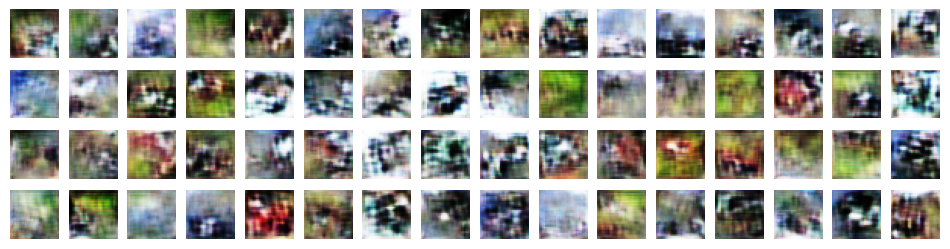

Time for epoch 1 is 5.7930 sec G loss: 1.2409 D loss: 0.9267
Time for epoch 2 is 5.7984 sec G loss: 1.4687 D loss: 0.8288
Time for epoch 3 is 5.7929 sec G loss: 1.4827 D loss: 0.8380
Time for epoch 4 is 5.7958 sec G loss: 1.4737 D loss: 0.8858
Time for epoch 5 is 5.7963 sec G loss: 1.5051 D loss: 0.8440
Time for epoch 6 is 5.7904 sec G loss: 1.5817 D loss: 0.8350
Time for epoch 7 is 5.8016 sec G loss: 1.6392 D loss: 0.8095
Time for epoch 8 is 5.8004 sec G loss: 1.7029 D loss: 0.7822
Time for epoch 9 is 5.7958 sec G loss: 1.7005 D loss: 0.7928
Time for epoch 10 is 5.7977 sec G loss: 1.7521 D loss: 0.7978


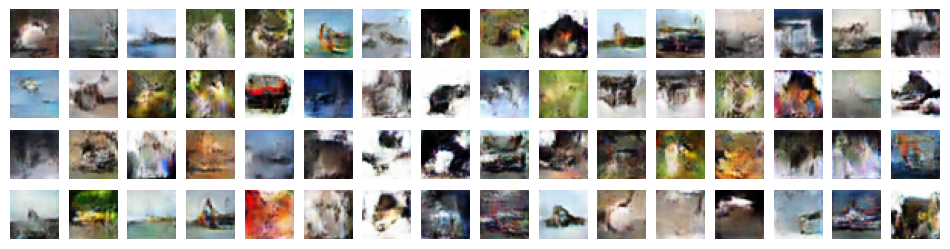

Time for epoch 11 is 5.7934 sec G loss: 1.7393 D loss: 0.8060
Time for epoch 12 is 5.7957 sec G loss: 1.7092 D loss: 0.8153
Time for epoch 13 is 5.7939 sec G loss: 1.6996 D loss: 0.8304
Time for epoch 14 is 5.7960 sec G loss: 1.7238 D loss: 0.7968
Time for epoch 15 is 5.8011 sec G loss: 1.7843 D loss: 0.7892
Time for epoch 16 is 5.7936 sec G loss: 1.7563 D loss: 0.7830
Time for epoch 17 is 5.7960 sec G loss: 1.7465 D loss: 0.7883
Time for epoch 18 is 5.7987 sec G loss: 1.7895 D loss: 0.7763
Time for epoch 19 is 5.8011 sec G loss: 1.7750 D loss: 0.7747
Time for epoch 20 is 5.7962 sec G loss: 1.8246 D loss: 0.7697


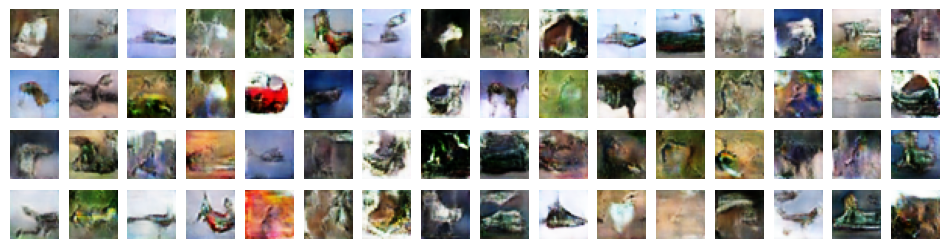

Time for epoch 21 is 5.7995 sec G loss: 1.8377 D loss: 0.7450
Time for epoch 22 is 5.7959 sec G loss: 1.9162 D loss: 0.7477
Time for epoch 23 is 5.7953 sec G loss: 1.8966 D loss: 0.7346
Time for epoch 24 is 5.7884 sec G loss: 1.8790 D loss: 0.7258
Time for epoch 25 is 5.7965 sec G loss: 1.9345 D loss: 0.7285
Time for epoch 26 is 5.7955 sec G loss: 1.9595 D loss: 0.7189
Time for epoch 27 is 5.7970 sec G loss: 1.9208 D loss: 0.7338
Time for epoch 28 is 5.7987 sec G loss: 1.9364 D loss: 0.7389
Time for epoch 29 is 5.7912 sec G loss: 1.9352 D loss: 0.7395
Time for epoch 30 is 5.7982 sec G loss: 1.9967 D loss: 0.7053


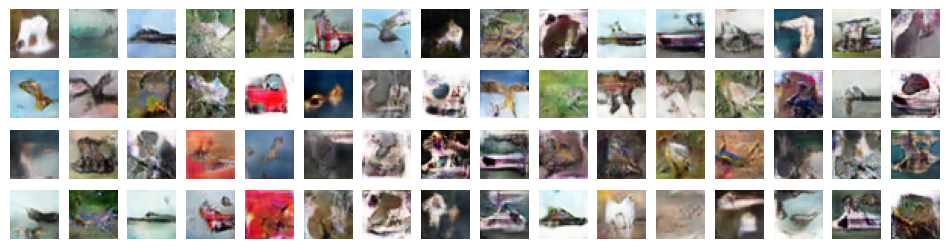

Time for epoch 31 is 5.8003 sec G loss: 2.0195 D loss: 0.6902
Time for epoch 32 is 5.7926 sec G loss: 2.0636 D loss: 0.6879
Time for epoch 33 is 5.7918 sec G loss: 2.0609 D loss: 0.6785
Time for epoch 34 is 5.7916 sec G loss: 2.1223 D loss: 0.6498
Time for epoch 35 is 5.7930 sec G loss: 2.2403 D loss: 0.6433
Time for epoch 36 is 5.7924 sec G loss: 2.1535 D loss: 0.6518
Time for epoch 37 is 5.7902 sec G loss: 2.2106 D loss: 0.6310
Time for epoch 38 is 5.7881 sec G loss: 2.2296 D loss: 0.6372
Time for epoch 39 is 5.7929 sec G loss: 2.2763 D loss: 0.6169
Time for epoch 40 is 5.7920 sec G loss: 2.3334 D loss: 0.5989


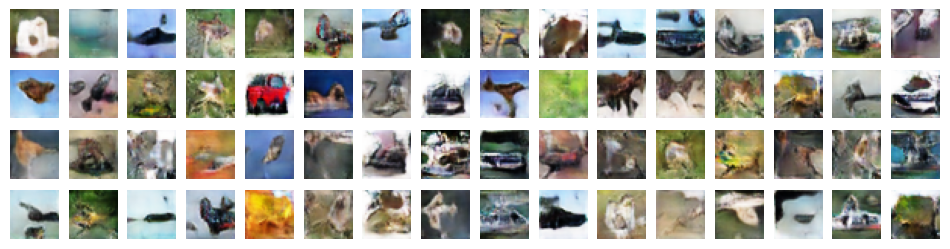

Time for epoch 41 is 5.7956 sec G loss: 2.3743 D loss: 0.5897
Time for epoch 42 is 5.7941 sec G loss: 2.3392 D loss: 0.6087
Time for epoch 43 is 5.7967 sec G loss: 2.3611 D loss: 0.6042
Time for epoch 44 is 5.7972 sec G loss: 2.3873 D loss: 0.5876
Time for epoch 45 is 5.7952 sec G loss: 2.4205 D loss: 0.5825
Time for epoch 46 is 5.7919 sec G loss: 2.5462 D loss: 0.5511
Time for epoch 47 is 5.7937 sec G loss: 2.5315 D loss: 0.5504
Time for epoch 48 is 5.7953 sec G loss: 2.5780 D loss: 0.5356
Time for epoch 49 is 5.7920 sec G loss: 2.5672 D loss: 0.5456


In [23]:
g_opt = tf.keras.optimizers.Adam(learning_rate=g_lr, 
                                 beta_1=beta_1, 
                                 beta_2=beta_2)

d_opt = tf.keras.optimizers.Adam(learning_rate=d_lr, 
                                 beta_1=beta_1,
                                 beta_2=beta_2)

generator = Generator(64, 128)
discriminator = Discriminator(128, use_bn=True)

gan = GAN(generator, discriminator, 
            g_opt, d_opt, 
            generator_loss, discriminator_loss)

train(gan, epochs, train_dataset, plot_inter)